Neste ficheiro testamos e exploramos a aplicação, no modelo III, de todo o tipo de transformações incluindo transformações que destorcem a imagem.

# Imports and Configurations

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torchinfo

import kornia

import matplotlib.pyplot as plt
import numpy as np
import time

import os
import pathlib
from PIL import Image
import skimage
from tqdm import tqdm

# importing a module with utilities for displaying stats and data
import sys
sys.path.insert(1, '../util')
import vcpi_util

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
# Paths
pathTrain = '../train_images/GTSRB/Final_Training/Images'
pathTest = '../test_images'

# Batch size - It can influence speed and generalization, not necessarily in the same direction. 
# There is no golden rule for the batch size but 32 is a commom number to start with.
BATCH_SIZE = 32

IMAGE_SIZE = 32
EPOCHS = 50

# Auxiliary Functions

In [4]:
def evaluate(model, data_loader):

    # sets the model in evaluation mode.
    # although our model does not have layers which behave differently during training and evaluation
    # this is a good practice as the models architecture may change in the future
    model.eval()

    correct = 0
    
    for i, (images, targets) in enumerate(data_loader):
         
        # forward pass, compute the output of the model for the current batch
        outputs = model(images.to(device))

        # "max" returns a namedtuple (values, indices) where values is the maximum 
        # value of each row of the input tensor in the given dimension dim; 
        # indices is the index location of each maximum value found (argmax).
        # the argmax effectively provides the predicted class number        
        _, preds = torch.max(outputs, dim=1)

        correct += (preds.cpu() == targets).sum()

    return (correct / len(data_loader.dataset)).item()

In [5]:
from skimage.util import random_noise

class RandomMotionBlur:
    def __init__(self, kernel_size=9, angle=180.0, direction=-0.5, p=0.5):
        self.kernel_size = kernel_size
        self.angle = angle
        self.direction = direction
        self.p = p

    def __call__(self, img):
        # Normalize to [0, 1]
        img = img.float() / 255.0

        if torch.rand(1) < self.p:
            img = kornia.filters.motion_blur(img.unsqueeze(0), self.kernel_size, self.angle, self.direction)
            return img.squeeze(0)
        else:
            return img
        
class Noise:
    def __init__(self, mean=0, var=0.05, p=0.5):
        self.mean = mean
        self.var = var
        self.p = p

    def __call__(self, img):
        if torch.rand(1) < self.p:
            noisy_img = torch.tensor(random_noise(img, mode='speckle', mean=self.mean, var=self.var, clip=True))
            return noisy_img
        else:
            return img

# Prepare and Load Data

In [6]:
# Convert the images from ppm to png
from PIL import Image
import glob
def ppm2png():
    images = glob.glob(f'{pathTrain}/**/*.ppm',recursive=True)
    for image in images:
        im = Image.open(image)
        new_filename = image[:-4] + '.png'
        im.save(new_filename)
        if image.endswith('.ppm'):
            os.remove(image)

    images = glob.glob(f'{pathTest}/**/*.ppm',recursive=True)
    for image in images:
        im = Image.open(image)
        new_filename = image[:-4] + '.png'
        im.save(new_filename)
        if image.endswith('.ppm'):
            os.remove(image)
#ppm2png()

Aqui testamos as diversas transformações criadas com o objetivo de simular imagens desfocadas ou com pouca qualidade. Para isso, utilizamos as funções RandomMotionBlur e Noise tanto no dataset original como no novo.

In [7]:
from torchvision.transforms import v2

transform_train = v2.Compose([
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    v2.ToImage(),
    Noise(var=0.01,p=0.3),
    v2.ToPILImage(),
    v2.RandomAutocontrast(p=1.0), # Apply autocontrast to the image
    v2.RandomRotation(15),                             # Will rotate the image randomly by an angle of -15 to 15 degrees
    v2.RandomPerspective(distortion_scale=0.5, p=0.3), # Apply a random perspective transformation to the image
    v2.ToImage(),                                      # Convert to image
    v2.ToDtype(torch.float32, scale=True)              # Normalize to [0,1]
])

transform_test = v2.Compose([
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    v2.RandomAutocontrast(p=1.0),          # Apply autocontrast to the image
    v2.ToImage(),                          
    v2.ToDtype(torch.float32, scale=True)  # Normalize to [0,1]
])

In [8]:
new_transform_train = v2.Compose([
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    v2.ColorJitter(brightness=0.5),        # Randomly change the brightness image by a factor of 0.3 (0.7 to 1.3)
    v2.ToImage(),
    RandomMotionBlur(kernel_size=7,p=0.5), # Apply motion blur with a given probability
    Noise(var=0.01,p=0.4),
    v2.ToPILImage(),
    v2.RandomErasing(p=0.4, scale=(0.02, 0.10)), # Randomly erase the image
    v2.RandomCrop(IMAGE_SIZE, padding=4),  # Crop the image to a random size of (32, 32)
    v2.ToImage(),                          
    v2.ToDtype(torch.float32, scale=True)  # Normalize to [0,1]
])

In [9]:
new_train_set = torchvision.datasets.ImageFolder(root=pathTrain, transform=new_transform_train)

In [10]:
train_set = torchvision.datasets.ImageFolder(root=pathTrain, transform=transform_train)

In [11]:
increased_dataset = torch.utils.data.ConcatDataset([train_set, new_train_set])

In [12]:
generator1 = torch.Generator().manual_seed(42)
train_set, val_set = torch.utils.data.random_split(increased_dataset, [0.7,0.3], generator=generator1)

train_loader = torch.utils.data.DataLoader(increased_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_loader = torch.utils.data.DataLoader(val_set, batch_size = BATCH_SIZE)

test_set = torchvision.datasets.ImageFolder(root=pathTest, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE)

In [13]:
images, targets = next(iter(train_loader))
print("Batch shape: ", images.shape) # [batch_size, channels, height, width]
print(targets) 

Batch shape:  torch.Size([32, 3, 32, 32])
tensor([ 4,  4,  1, 36, 15,  6,  4,  5, 10,  3, 17, 33, 16, 10, 13, 13, 37,  9,
         3, 38, 17,  2,  4, 11,  5,  1, 38,  8, 18, 23, 38, 38])


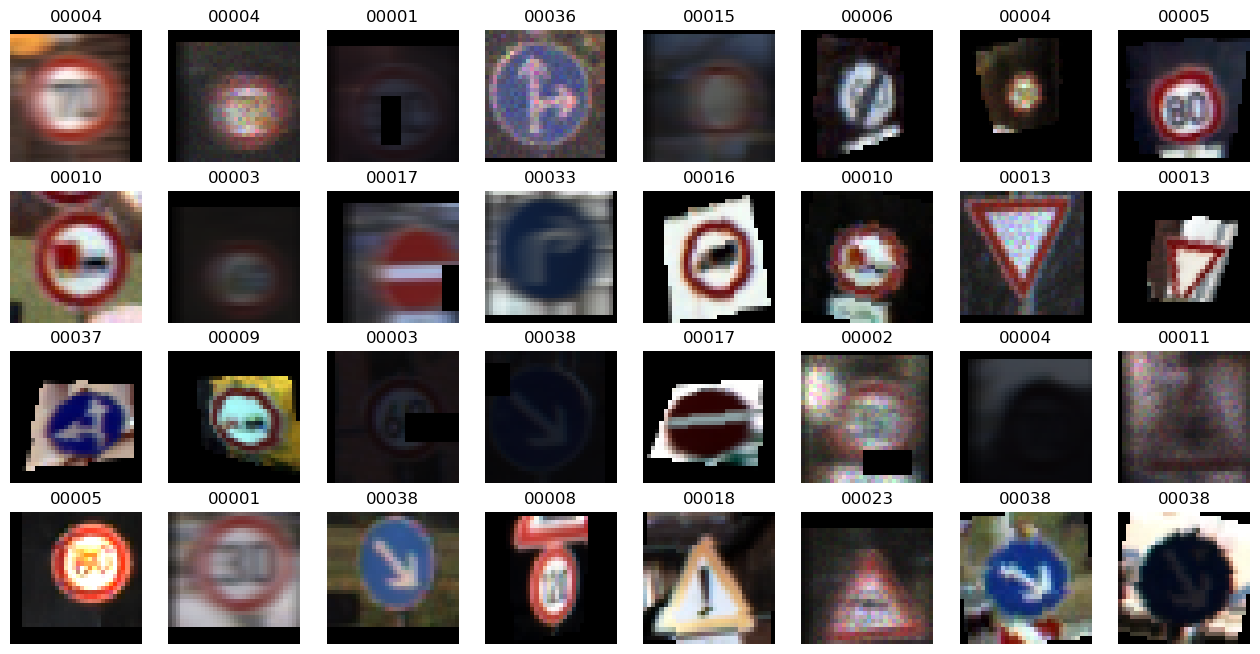

<Figure size 640x480 with 0 Axes>

In [14]:
vcpi_util.show_images(4,8,images, targets, increased_dataset.datasets[0].classes)

# Treino

In [16]:
class Conv(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(3, 128, 3) 
        self.bn1 = torch.nn.BatchNorm2d(128)    
        self.relu1 = torch.nn.ReLU()
        self.drop1 = torch.nn.Dropout2d(0.3)

        self.conv2 = torch.nn.Conv2d(128, 256, 3)
        self.bn2 = torch.nn.BatchNorm2d(256)
        self.relu2 = torch.nn.ReLU()
        self.drop2 = torch.nn.Dropout2d(0.3)

        self.maxpool1 = torch.nn.MaxPool2d(2)

        self.conv3 = torch.nn.Conv2d(256, 512, 3)
        self.bn3 = torch.nn.BatchNorm2d(512)        
        self.relu3 = torch.nn.ReLU()
        self.drop3 = torch.nn.Dropout2d(0.3)

        self.conv4 = torch.nn.Conv2d(512, 512, 3)
        self.bn4 = torch.nn.BatchNorm2d(512)
        self.relu4 = torch.nn.ReLU()
        self.drop4 = torch.nn.Dropout2d(0.3)

        self.maxpool2 = torch.nn.MaxPool2d(2)

        self.fc1 = torch.nn.Linear(12800, num_classes) 

    def forward(self, x):
        # input = (batch_size, 3, 32, 32)
        x = self.conv1(x)                  # output = (batch_size, 128, 30, 30) 
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.drop1(x)

        x = self.conv2(x)                  # output = (batch_size, 256, 28, 28)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.drop2(x)

        x = self.maxpool1(x)               # output = (batch_size, 256, 14, 14)

        x = self.conv3(x)                  # output = (batch_size, 512, 12, 12)                     
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.drop3(x)

        x = self.conv4(x)                  # output = (batch_size, 512, 10, 10)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.drop4(x)

        x = self.maxpool2(x)               # output = (batch_size, 512, 5, 5)     512 x 5 x 5 = 12800

        x = torch.flatten(x, 1)             
        x = self.fc1(x)                                                                                     

        return x 
    
model_I = Conv(len(increased_dataset.datasets[0].classes))
model_I.to(device)
print(model_I)

torchinfo.summary(model_I, input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE))

Conv(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (drop1): Dropout2d(p=0.3, inplace=False)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (drop2): Dropout2d(p=0.3, inplace=False)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (drop3): Dropout2d(p=0.3, inplace=False)
  (conv4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (drop4): Dropout2d(p=0.3, inplace=False)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, pa

Layer (type:depth-idx)                   Output Shape              Param #
Conv                                     [32, 43]                  --
├─Conv2d: 1-1                            [32, 128, 30, 30]         3,584
├─BatchNorm2d: 1-2                       [32, 128, 30, 30]         256
├─ReLU: 1-3                              [32, 128, 30, 30]         --
├─Dropout2d: 1-4                         [32, 128, 30, 30]         --
├─Conv2d: 1-5                            [32, 256, 28, 28]         295,168
├─BatchNorm2d: 1-6                       [32, 256, 28, 28]         512
├─ReLU: 1-7                              [32, 256, 28, 28]         --
├─Dropout2d: 1-8                         [32, 256, 28, 28]         --
├─MaxPool2d: 1-9                         [32, 256, 14, 14]         --
├─Conv2d: 1-10                           [32, 512, 12, 12]         1,180,160
├─BatchNorm2d: 1-11                      [32, 512, 12, 12]         1,024
├─ReLU: 1-12                             [32, 512, 12, 12]       

With Early Stopping

In [17]:
class Early_Stopping():

    def __init__(self, patience = 3, min_delta = 0.00001):
        self.patience = patience 
        self.min_delta = min_delta

        self.min_delta
        self.min_val_loss = float('inf')

    def __call__(self, val_loss):
        # improvement
        if val_loss + self.min_delta < self.min_val_loss:
            self.min_val_loss = val_loss
            self.counter = 0

        # no improvement            
        else:
            self.counter += 1
            if self.counter > self.patience:
                return True
            
        return False

Uma vez que este modelo e respetivas transformações foram os que tiveram melhores resultados durante os testes decidimos aplicar um learning rate scheduler de formma a ajustar a taxa de aprendizagem do treino do modelo.

c:\Users\Marta\miniconda3\envs\myenv\Lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


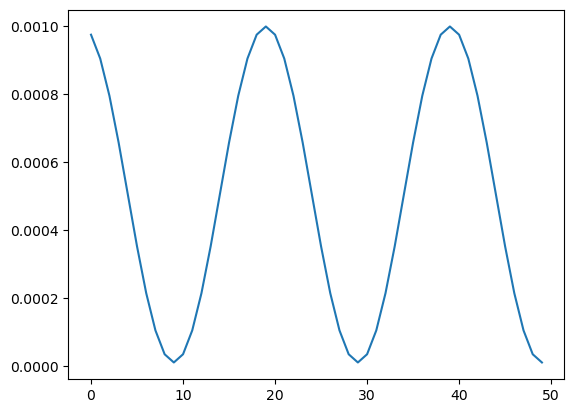

In [18]:
optimizer_aux = torch.optim.Adam(model_I.parameters(), lr=0.001)

#scheduler = torch.optim.lr_scheduler.LinearLR(optimizer_aux, start_factor=1, end_factor=0.1, total_iters =20)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_aux, 10, 0.00001)

lrs = []
for epoch in range(EPOCHS):
    scheduler.step()
    lrs.append(scheduler.get_last_lr())

plt.plot(lrs)

In [19]:
def train(model, train_loader, test_loader, epochs, loss_fn, optimizer, scheduler, early_stopper):
    history = {}
    history['accuracy'] = []
    history['val_acc'] = []
    history['val_loss'] = []
    #history['test_acc'] = []
    #history['test_loss'] = []
    history['loss'] = []
    best_val_loss = np.inf

    for epoch in range(epochs):  # loop over the dataset multiple times

        model.train()
        start_time = time.time() 
        correct = 0
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(train_loader, 0):
            
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            loss = loss_fn(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss
            correct += (predicted == targets).sum()

        model.eval()
        with torch.no_grad():
            t_correct = 0
            val_loss = 0.0            
            for i,t in val_loader:
                i, t = i.to(device), t.to(device)
                o = model(i)
                _,p = torch.max(o,1)
                
                val_loss += loss_fn(o, t)

                t_correct += (p == t).sum()

        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        
        if old_lr != new_lr:
            print('==> Learning rate updated: ', old_lr, ' -> ', new_lr)

        epoch_loss = running_loss / len(train_loader.dataset)
        accuracy = 100 * correct / len(train_loader.dataset)
        t_accuracy = 100 * t_correct / len(val_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        stop_time = time.time()
        print(f'Epoch: {epoch:03d}; Loss: {epoch_loss:0.6f}; Accuracy: {accuracy:0.4f}; Val Acc: {t_accuracy:0.4f}; Elapsed time: {(stop_time - start_time):0.4f}')
        history['accuracy'].append(accuracy.cpu().numpy())
        history['val_acc'].append(t_accuracy.cpu().numpy())
        history['val_loss'].append(val_loss.cpu().detach().numpy())
        history['loss'].append(epoch_loss.cpu().detach().numpy())

        if early_stopper(val_loss):
            print('Early stopping!')
            break
        
    print('Finished Training')

    return(history)

In [20]:
optimizer_I = torch.optim.Adam(model_I.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_I, mode='min', factor = 0.1, patience=10)
early_stop = Early_Stopping(25)

history_I = train(model_I,train_loader,val_loader,EPOCHS,loss_fn,optimizer_I,scheduler,early_stop)

In [ ]:
evaluate(model_I, test_loader)

In [ ]:
###### Saving ######
# torch.save({
#     'epoch': EPOCHS,
#     'model':model_I.state_dict(),
#     'optimizer': optimizer_I.state_dict(),
#     'history' : history_I
#     },
#     f'model_III_oclude.pt')

# Análise dos Resultados

Verificar o histórico de accuracy do dataset de treino e de teste e o histórico de loss 

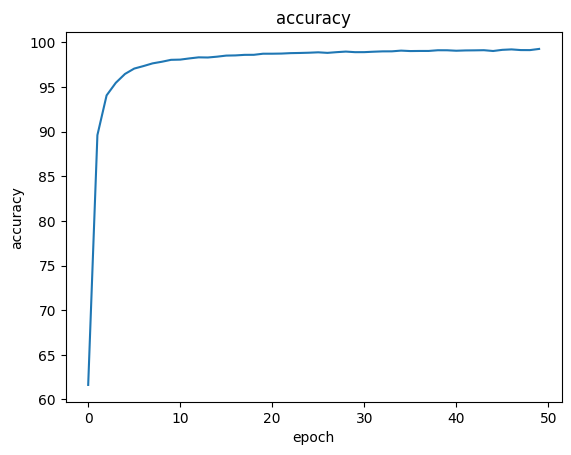

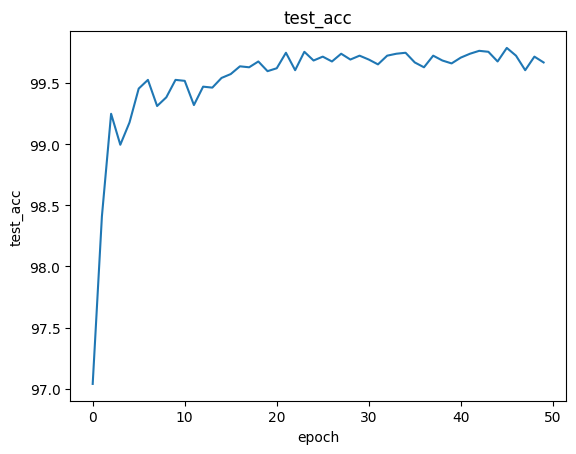

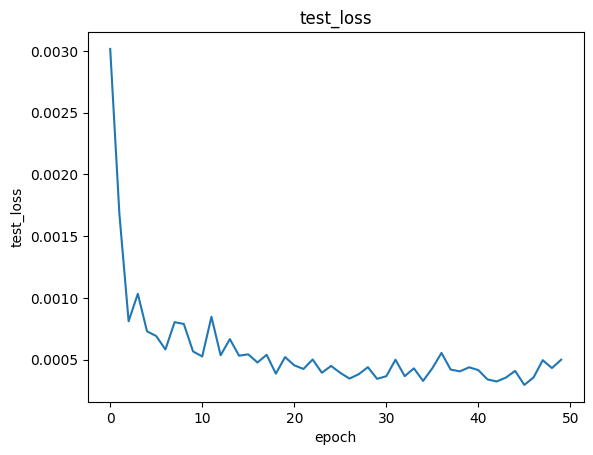

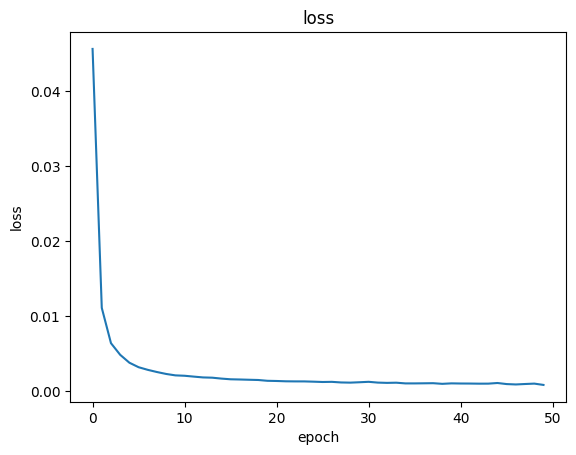

In [ ]:
vcpi_util.show_history(history_I)

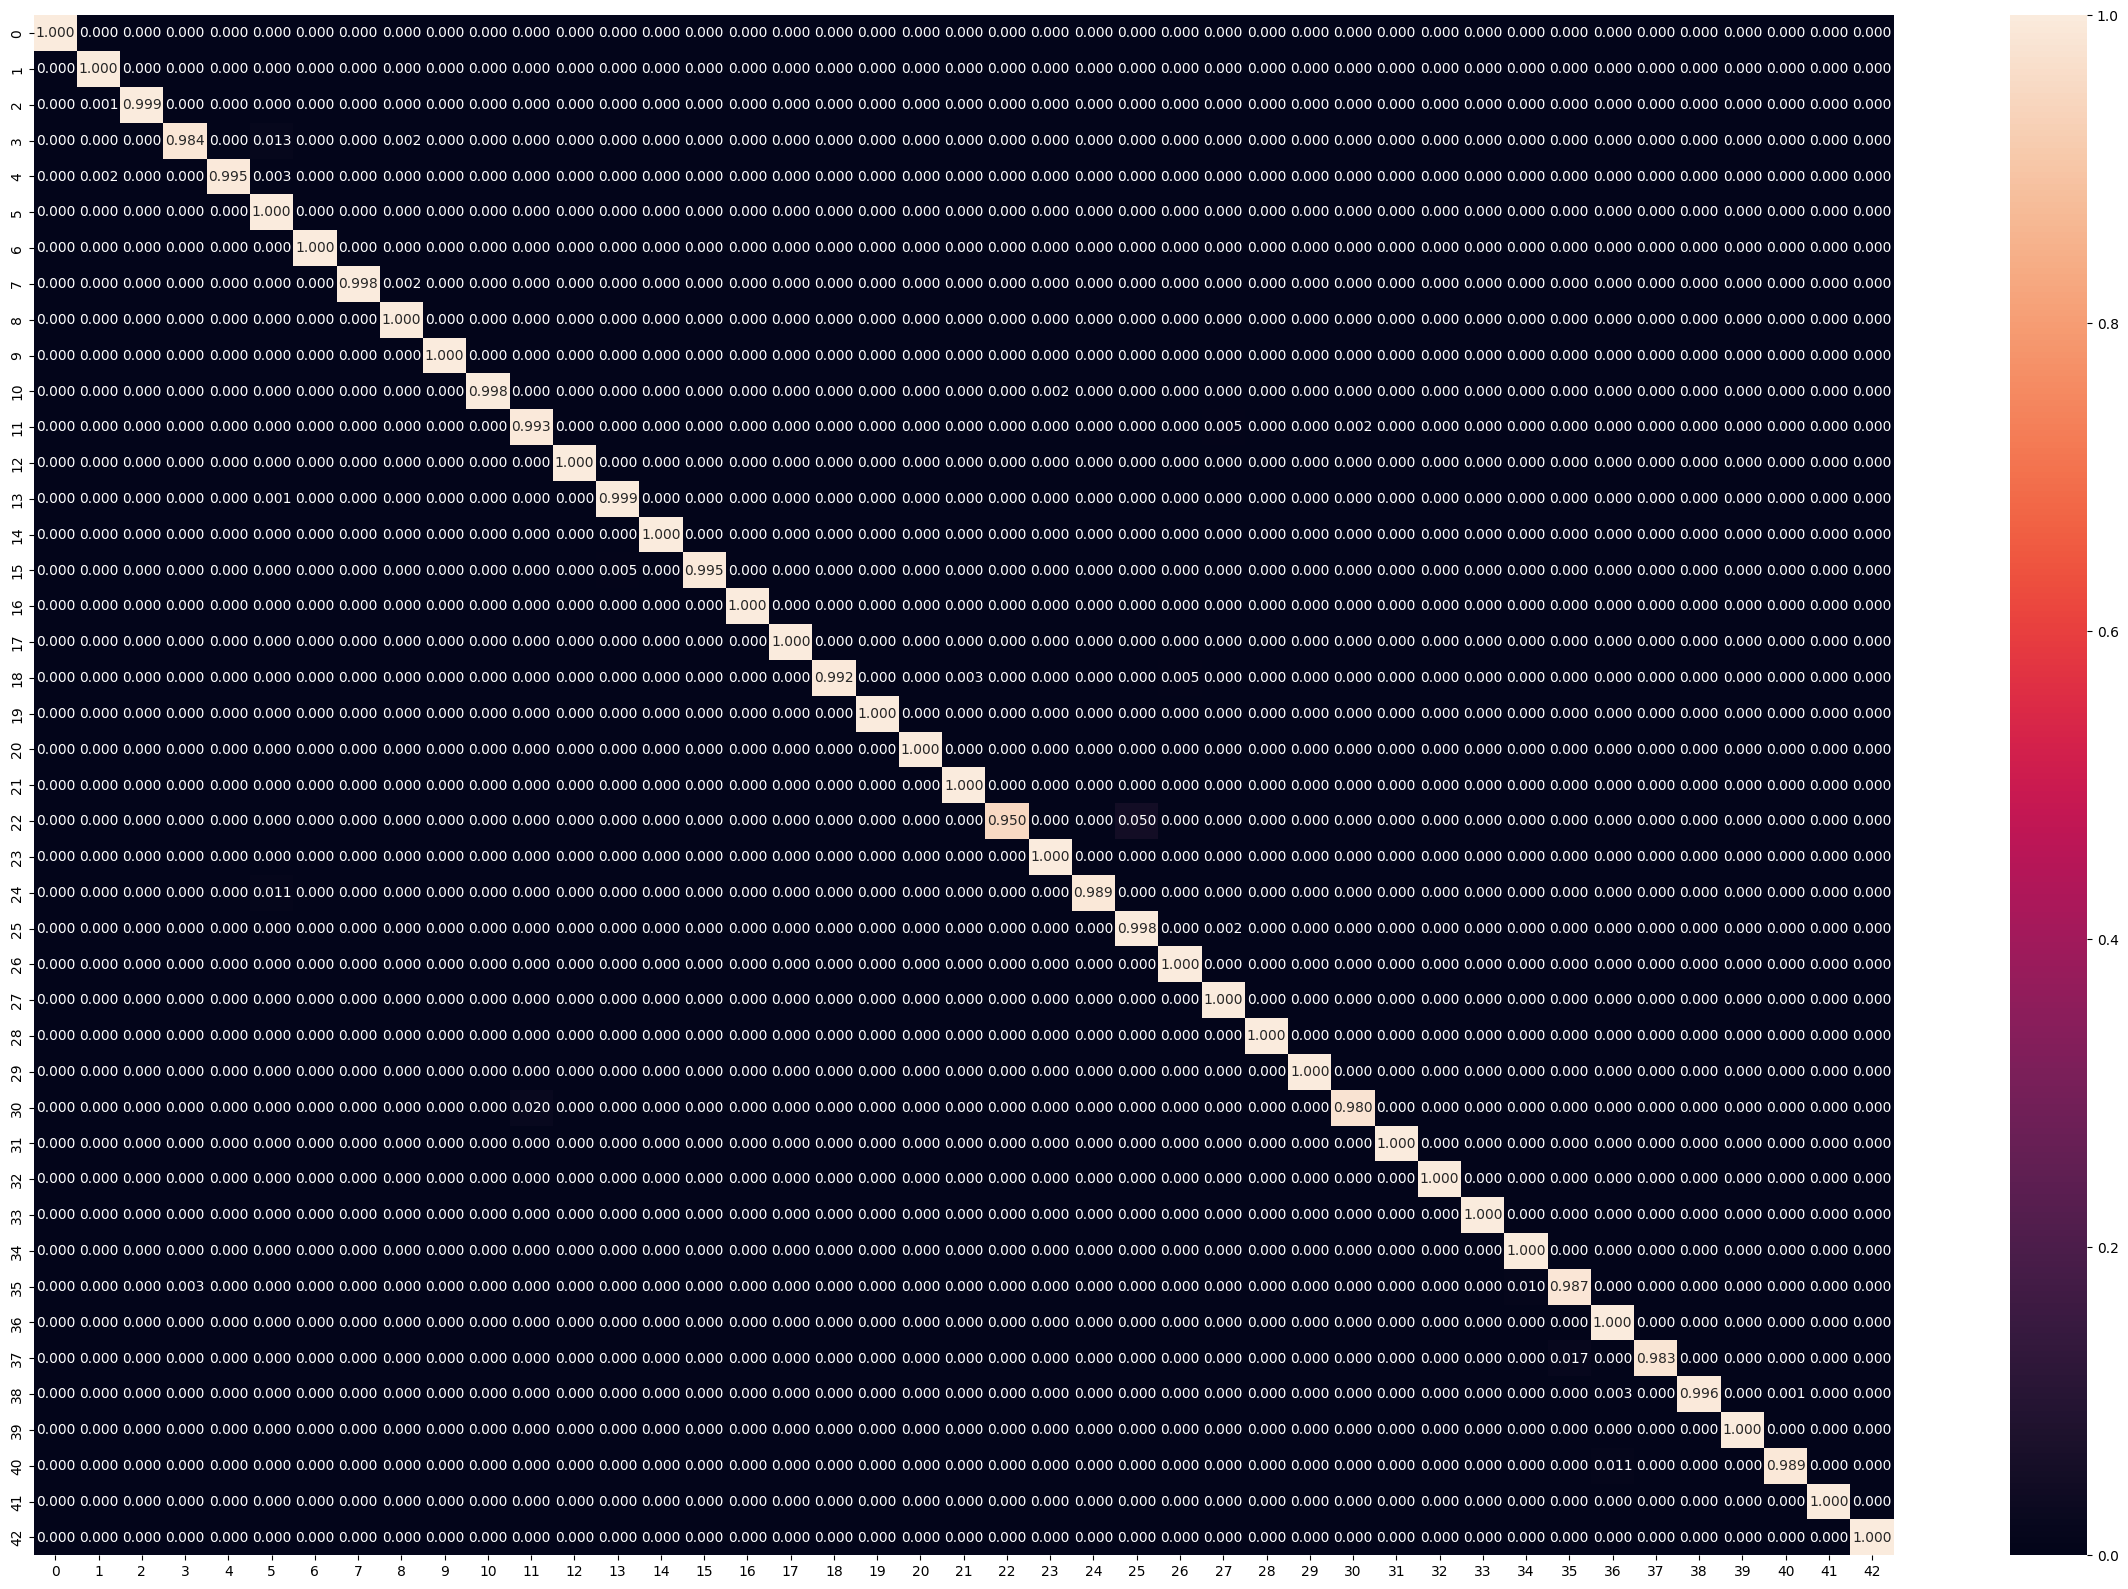

In [ ]:
preds = []
ground_truth = []

for images, targets in test_loader:
    logits = model_I(images.to(device))
    preds_aux = [np.argmax(x) for x in logits.cpu().detach().numpy()]
    preds.extend(preds_aux) 
    ground_truth.extend(targets.numpy())

vcpi_util.show_confusion_matrix(ground_truth, preds, len(increased_dataset.datasets[0].class_to_idx))

A partir da análise da matriz de correlação podemos verificar que as classes, de forma geral tiveram um bom desempenho pelo que estamos satisfeitos com os resultados obtidos.

Verificar as imagens mal classificadas

In [ ]:
def show_bad_preds(model, dataset, classes):
    k = 0
    iters = 0

    preds = []
    ground_truth = []
    imgs = torch.Tensor(BATCH_SIZE, 3, IMAGE_SIZE,IMAGE_SIZE)

    iterator = iter(dataset)

    max_iters = test_set.__len__() / BATCH_SIZE
    while k < 32 and iters < max_iters:

        images, targets = next(iterator)
        #print(images[0].shape)
        logits = model(images.to(device))
        
        #print(predictions[0])
        predictions = torch.nn.functional.softmax(logits, dim=1).cpu().detach().numpy()
        for i in range(len(predictions)):

            if np.argmax(predictions[i]) != targets[i] and k < 32:

                preds.append(predictions[i])
                ground_truth.append(targets[i])
                imgs[k, :, :, :] = images[i]
                k += 1

        iters += 1

    vcpi_util.plot_predictions(imgs, preds, ground_truth, classes, 10, 3)

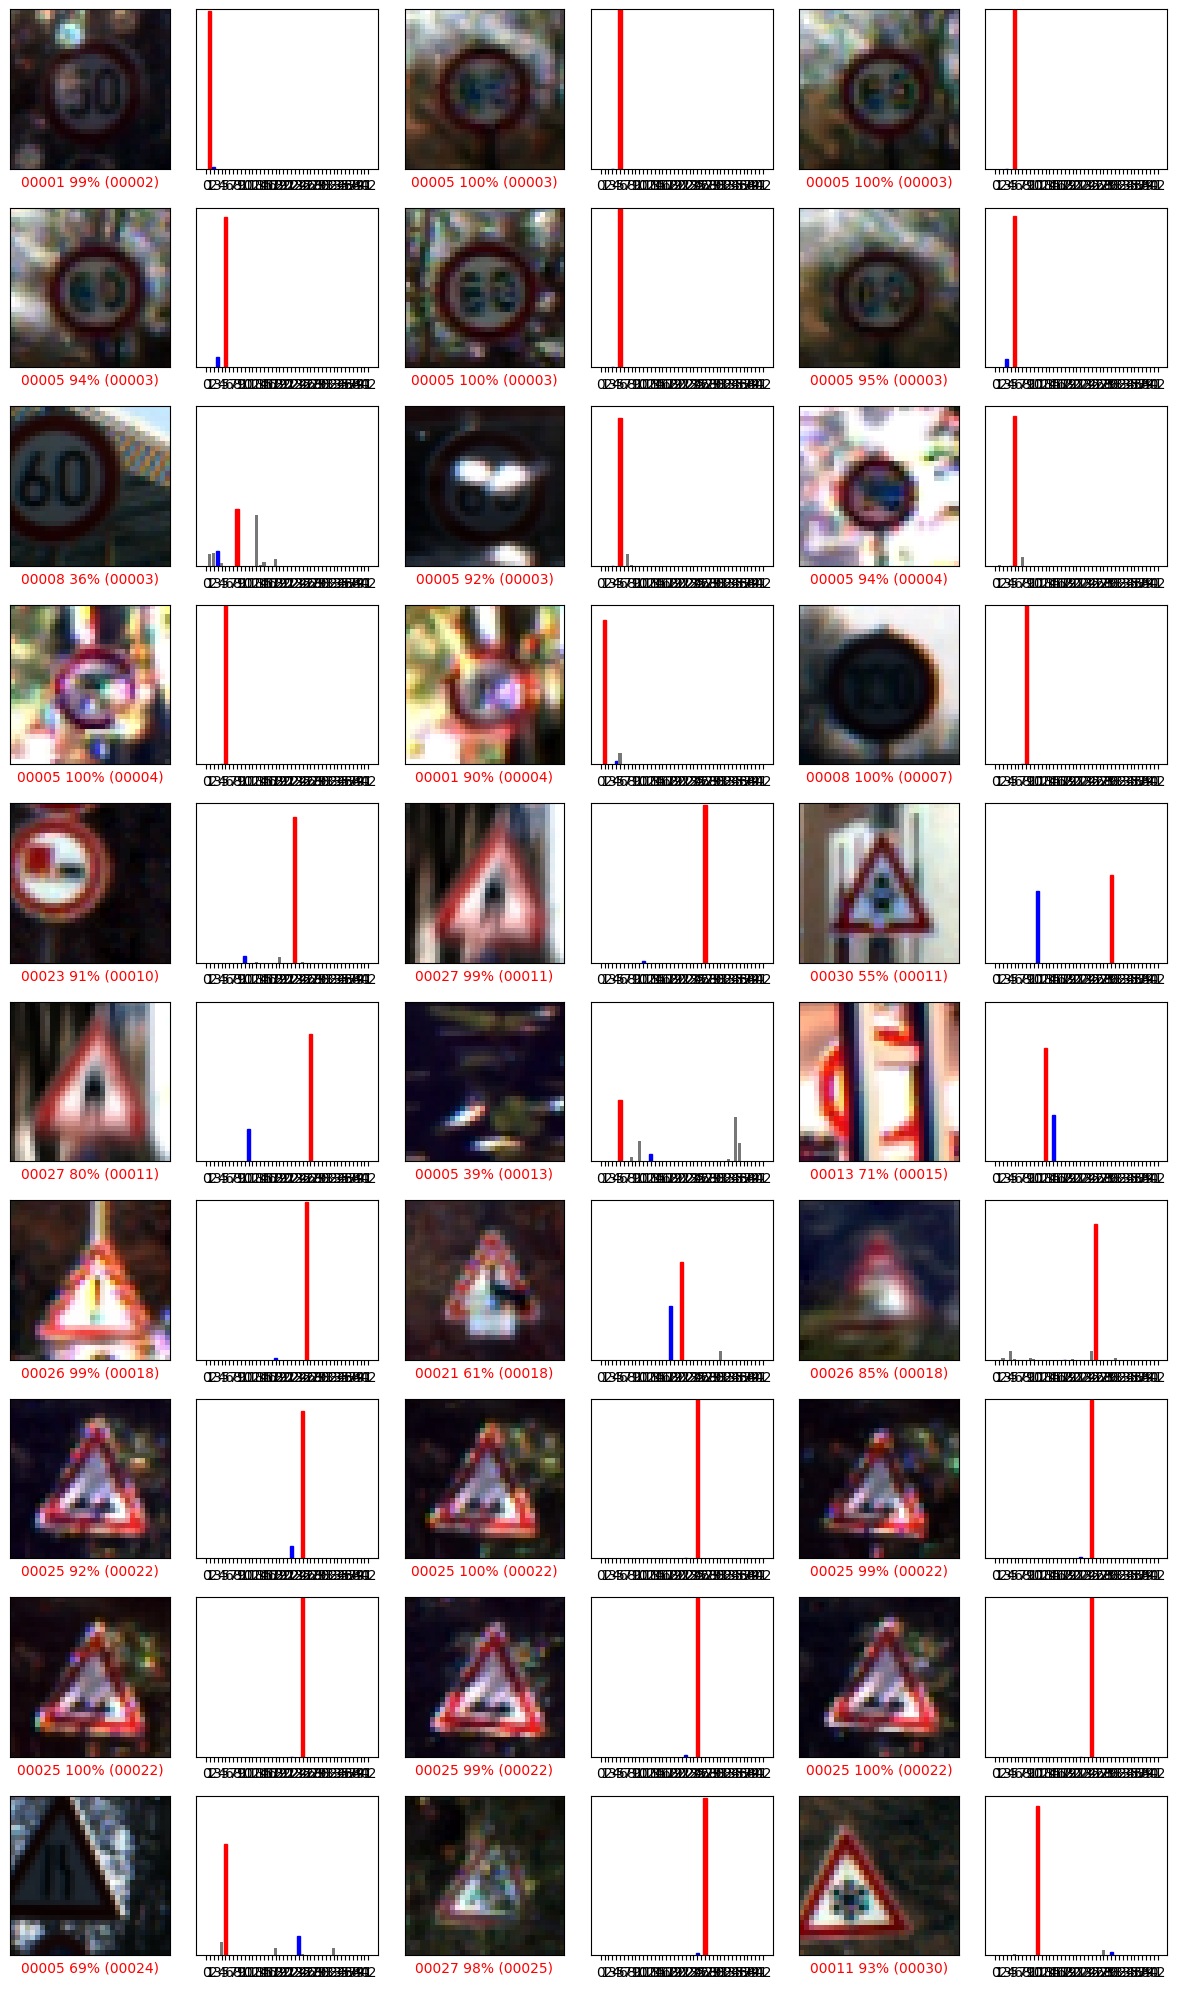

In [ ]:
show_bad_preds(model_I, test_loader, test_set.classes)

Como podemos observar ainda assim existem algumas imagens mal classificadas. Esta situação podia ser melhorada ajustando, por exemplo as transformações utilizadas e os seus respetivos parâmetros, os modelos utilizados, entre outras abordagens. 